In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree

# Preprocessing section
### Dropping Columns we know we don't want right away and then merging the different csv files to get additional columns we want

In [2]:
df = pd.read_csv("./archive/job_postings.csv")
columns_to_drop = ['expiry', 'skills_desc', 'posting_domain', 'compensation_type', 'sponsored', 'currency', 'listed_time',
                   'job_posting_url', 'application_url', 'application_type', 'closed_time', 'applies', 'views', 'remote_allowed',
                  'original_listed_time', 'description', 'work_type']

# drop columns we know we don't want
df = df.drop(columns=columns_to_drop)

# joining the different data sets
emp_count_df = pd.read_csv('./archive/employee_counts.csv')
emp_count_df = emp_count_df[['company_id', 'employee_count']]
emp_count_df = emp_count_df.drop_duplicates(subset = ['company_id'])

comp_ind = pd.read_csv("./archive/company_industries.csv")
comp_ind = comp_ind.drop_duplicates(subset = ['company_id'])

comp_size = pd.read_csv("./archive/companies.csv")
comp_size = comp_size[['company_id', 'company_size']]
comp_size = comp_size.drop_duplicates(subset = ['company_id'])

skills_abr = pd.read_csv("./archive/job_skills.csv")
skills_abr = skills_abr[['skill_abr', 'job_id']]

# One hot encode skills_abr for each job_id
skills_abr = pd.get_dummies(skills_abr, columns=['skill_abr'])
skills_abr = skills_abr.groupby('job_id').sum().reset_index()

df = df.merge(emp_count_df, how='inner', on='company_id')
df = df.merge(comp_ind,  how='inner', on='company_id')
df = df.merge(comp_size,  how='inner', on='company_id')
df = df.merge(skills_abr,  how='inner', on='job_id')


### Getting rid of null experience level and salaries. Then fixing the salary columns and getting rid of outliers in them

In [3]:
# get rid of null experience level
unique_levels = df['formatted_experience_level'].unique()[1:]
df = df[df['formatted_experience_level'].isin(unique_levels)]

#drop null salaries
df = df.dropna(subset=['pay_period', 'min_salary', 'max_salary'])

In [4]:
# making all pay the same rates
df.loc[df['pay_period'] == 'HOURLY', 'max_salary'] = df['max_salary'] * 40 * 52
df.loc[df['pay_period'] == 'WEEKLY', 'max_salary'] = df['max_salary'] * 52
df.loc[df['pay_period'] == 'MONTHLY', 'max_salary'] = df['max_salary'] * 12

df.loc[df['pay_period'] == 'HOURLY', 'min_salary'] = df['min_salary'] * 40 * 52
df.loc[df['pay_period'] == 'WEEKLY', 'min_salary'] = df['min_salary'] * 52
df.loc[df['pay_period'] == 'MONTHLY', 'min_salary'] = df['min_salary'] * 12

df.loc[df['pay_period'] == 'HOURLY', 'med_salary'] = df['med_salary'] * 40 * 52
df.loc[df['pay_period'] == 'WEEKLY', 'med_salary'] = df['med_salary'] * 52
df.loc[df['pay_period'] == 'MONTHLY', 'med_salary'] = df['med_salary'] * 12

# we know all salaries are annual, so we drop the pay_period column
df = df.drop(columns=['pay_period'])

# impute missing median salary now we have correct rates for min and max
df.loc[df['med_salary'].isna(), 'med_salary'] = (df['max_salary'] + df['min_salary']) / 2

In [5]:
# Drop outliers for min and max salary

df = df[df['max_salary'] > 5000]
df = df[df['max_salary'] <= 350000]

df = df[df['min_salary'] > 5000]
df = df[df['min_salary'] <= 350000]

# Drop rows with null columns now that we have salary columns fixed
df = df.dropna()

# scaling the salary columns. they'll be in 10s of thousands 
df["min_salary"] = df["min_salary"].apply(lambda sal: sal / 10000)
df["max_salary"] = df["max_salary"].apply(lambda sal: sal / 10000)
df["med_salary"] = df["med_salary"].apply(lambda sal: sal / 10000)

### Fixing the location column to conform to state abbreviation or other. Then encoding this column
A graph is included to showcase the distribution of jobs with respect to location

In [6]:
# here we are trying to standardize the location column so we only get the abbreviated state name

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC"}

us_city_to_state= {
        'San': 'CA',
        'Atlanta': 'GA',
        'Grand Rapids': 'MI',
        'Detroit': 'MI',
        'Cincinnati': 'OH',
        'Denver': 'CO',
        'Los Angeles': 'CA',
        'Las Vegas': 'NV',
        'Seattle':'WA',
        'Miami-Fort': 'FL',
        'Chicago': 'IL',
        'Tampa': 'FL',
        'Salt Lake': 'UT',
        'Nashville': 'TN',
        'Buffalo-Niagara': 'NY',
        'Raleigh-Durham-Chapel': 'NC',
        'Huntsville-Decatur-Albertville':'AL',
        'Madison' : 'WI',
        'Minneapolis-St.': 'MN',
        'Dallas-Fort': 'TX',
        'Pittsburgh': 'PA',
        'Houston': 'TX',
        'Orlando': 'FL',
        'Memphis': 'TN',
        'Philadelphia': 'PA',
        'Phoenix': 'AZ',
        'AZ': 'AZ',
        'Charlotte': 'NC',
        'Cleveland':'OH'}

'''
This algorithm attempts to get the state from the location in the abbreviated format.
If it cannot, it lists it as other.
360 locations recovered
'''

locations = df['location'].values
counter = 0
counter2 = 0
for i in range(len(locations)):
    components = locations[i].split(',')
    
    # looked like always "state, US"
    if len(components) > 1 and components[-1].strip() == 'United States':
        counter += 1
        locations[i] = us_state_to_abbrev[components[-2].strip()]
        continue
    
    # checks for city, state abbrev
    loc = components[-1].strip()
    if len(loc) == 2:
        locations[i] = loc
        continue
    
    
    location = components[-1].split()[0].strip()
    if location in us_state_to_abbrev.keys():
        counter2 +=1
        locations[i] = us_state_to_abbrev[location]
        continue  
    elif location in us_city_to_state.keys():
        counter2 +=1
        locations[i] = us_city_to_state[location]
        continue
    
    if len(components[-1].split()) > 1:
        location = components[-1].split()[0].strip() + ' ' + components[-1].split()[1].strip()
        if location in us_state_to_abbrev.keys():
            counter2 +=1
            locations[i] = us_state_to_abbrev[location]
            continue
        elif location in us_city_to_state.keys():
            counter2 +=1
            locations[i] = us_city_to_state[location]
            continue

        location = components[-1].split()[1].strip()
        if location in us_state_to_abbrev.keys():
            counter2 +=1
            locations[i] = us_state_to_abbrev[location]
            continue
        elif location in us_city_to_state.keys():
            counter2 +=1
            locations[i] = us_city_to_state[location]
            continue
            
    locations[i] = 'other'

        
unique_locations = np.unique(locations)
        
df['location'] = locations

total locations recovered 444
Unique locations: ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'WA' 'WI' 'WV' 'WY' 'other']


In [7]:
# encoding location
le = LabelEncoder()
le.fit(unique_locations)
list(le.classes_)
locations = le.transform(locations)
df['location'] = locations

#encode title
le = LabelEncoder()
titles = df['title'].values
unique_titles = np.unique(titles)
le.fit(unique_titles)
list(le.classes_)
titles = le.transform(titles)
df['title'] = titles

### Encoded formatted_experience_level and formatted_work_type. Grouped the employee counts into bins

In [8]:
# fix formatted_experience_level column and ordinal encode

# ['Associate' 'Mid-Senior level' 'Entry level' 'Executive' 'Director' 'Internship'] 
# We want to combine Internship with entry, and Executive, Director into management
experience_lvls = ['Entry level', 'Associate', 'Mid-Senior level', 'Management']
fel_column = df['formatted_experience_level'].values
for i in range(len(fel_column)):
    level = fel_column[i].strip()
    if level in experience_lvls:
        fel_column[i] = level
        continue
    
    if level == 'Internship':
        fel_column[i] = 'Entry level'
    else:
        fel_column[i] = 'Management'

# set updated experience column
df['formatted_experience_level'] = fel_column

#ordinal encode
for i in range(len(fel_column)):
    level = fel_column[i]
    fel_column[i] = experience_lvls.index(level)
df['formatted_experience_level'] = fel_column

In [9]:
# fix formatted_work_type column and ordinal encode

# ['Full-time' 'Contract' 'Part-time' 'Temporary' 'Other' 'Internship']
# we'll group temporary with part-time and other with contract
work_type = ['Internship', 'Part-time', 'Contract', 'Full-time'] 
work_type_col = df['formatted_work_type'].values

for i in range(len(work_type_col)):
    type_ = work_type_col[i].strip()
    if type_ in work_type:
        work_type_col[i] = type_
        continue
    
    if type_ == 'Temporary':
        work_type_col[i] = 'Part-time'
    else:
        work_type_col[i] = 'Contract'

# set updated experience column
df['formatted_work_type'] = work_type_col

#ordinal encode
for i in range(len(work_type_col)):
    type_ = work_type_col[i]
    work_type_col[i] = work_type.index(type_)
df['formatted_work_type'] = work_type_col

In [10]:
# encode employee count column based off these groupings
def interval(value):
    k = 1000
    if value < 10*k:
        return 0
    elif value >= 10*k and value < 20*k:
        return 1
    elif value >= 20*k and value < 30*k:
        return 2
    elif value >= 30*k and value < 40*k:
        return 3
    elif value >= 40*k and value < 50*k:
        return 4
    elif value >= 50*k and value < 60*k:
        return 5
    elif value >= 60*k and value < 70*k:
        return 6
    elif value >= 70*k and value < 80*k:
        return 7
    elif value >= 80*k and value < 90*k:
        return 8
    elif value >= 90*k and value < 100*k:
        return 9
    elif value >= 100*k:
        return 10

df["employee_count"] = df["employee_count"].apply(interval)

In [11]:
# create boolean column that specifies whether the respective salaries are above average
above_avg_min = []
above_avg_med = []
above_avg_max = []

min_ = df['min_salary'].values
med_ = df['med_salary'].values
max_ = df['max_salary'].values

min_avg = np.mean(min_)
max_avg = np.mean(max_)
med_avg = np.mean(med_)


for sal in min_:
    if sal >= min_avg:
        above_avg_min.append(1)
    else:
        above_avg_min.append(0)
        
for sal in med_:
    if sal >= med_avg:
        above_avg_med.append(1)
    else:
        above_avg_med.append(0)
        
for sal in max_:
    if sal >= max_avg:
        above_avg_max.append(1)
    else:
        above_avg_max.append(0)
        
df['above_avg_min'] = above_avg_min
df['above_avg_med'] = above_avg_med
df['above_avg_max'] = above_avg_max

unique_industries = list(df.groupby('industry')['industry'].count().index)
industries = df['industry'].values
# encode industries 
le = LabelEncoder()
le.fit(unique_industries)
list(le.classes_)
industries = le.transform(industries)
df['industry'] = industries

In [ ]:
df

,job_id,company_id,title,max_salary,med_salary,min_salary,formatted_work_type,location,formatted_experience_level,employee_count,...,skill_abr_RSCH,skill_abr_SALE,skill_abr_SCI,skill_abr_STRA,skill_abr_SUPL,skill_abr_TRNG,skill_abr_WRT,above_avg_min,above_avg_med,above_avg_max
18,3699078816,1016.0,768,22.80000,19.00000,15.20000,3,50,3,5,...,0,1,0,0,0,0,0,1,1,1
20,3699079842,1016.0,932,8.98000,7.48000,5.98000,3,31,0,5,...,0,0,0,0,0,0,0,0,0,0
24,3699080691,1016.0,932,8.98000,7.48000,5.98000,3,38,0,5,...,0,0,0,0,0,0,0,0,0,0
29,3699082102,1016.0,932,8.98000,7.48000,5.98000,3,8,0,5,...,0,0,0,0,0,0,0,0,0,0
32,3699419984,1016.0,1310,11.40000,9.50000,7.60000,3,50,2,5,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14922,3701373493,5619.0,2500,10.52000,9.85500,9.19000,3,4,2,1,...,0,0,0,0,0,0,1,1,0,0
14923,3701372969,1192815.0,1207,11.47120,9.55968,7.64816,3,4,0,0,...,0,0,0,0,0,0,0,0,0,1
14924,3701372993,2670805.0,1401,11.00000,10.00000,9.00000,3,50,2,0,...,0,0,0,0,0,0,0,1,1,0
14929,3701373427,1321042.0,680,4.96912,4.46888,3.96864,0,9,2,0,...,0,0,0,0,0,0,0,0,0,0


### Naive Bayes

In [ ]:
# Implementing Naive Bayes. We want to see how well we can do this classification with skills and industry
features = df.loc[:,'skill_abr_ACCT':'skill_abr_WRT']
features['industry'] = df['industry']
target = df['above_avg_min']
target2 = df['above_avg_med']
target3 = df['above_avg_max']

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

# training model to predict if min salary is above avg
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(features, target, test_size=0.2)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_min, y_train_min)
print(nb_classifier.score(X_test_min, y_test_min))

0.6635262449528937


In [ ]:
# training model to predict if med salary is above avg
X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(features, target2, test_size=0.2)
nb_classifier2 = GaussianNB()
nb_classifier2.fit(X_train_med, y_train_med)
print(nb_classifier2.score(X_test_med, y_test_med))

0.6689098250336474


In [ ]:
# training model to predict if max salary is above avg
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(features, target3, test_size=0.2)
nb_classifier3 = GaussianNB()
nb_classifier3.fit(X_train_max, y_train_max)
print(nb_classifier3.score(X_test_max, y_test_max))

0.65814266487214


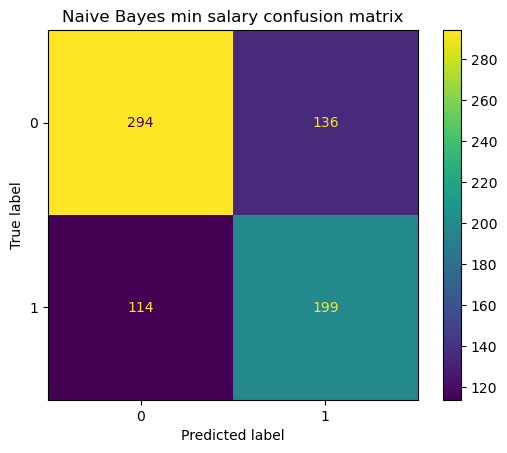

Precision: [0.72058824 0.59402985]
Recall: [0.68372093 0.63578275]
Fscore: [0.70167064 0.61419753]


In [ ]:
# creating the confusion matrix for min salary
predictions_min = nb_classifier.predict(X_test_min)
min_conf = confusion_matrix(y_test_min, predictions_min)
disp = ConfusionMatrixDisplay(confusion_matrix=min_conf)
disp.plot()
plt.title('Naive Bayes min salary confusion matrix')
plt.show()
precision, recall, fscore, _ = precision_recall_fscore_support(y_test_min, predictions_min)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Fscore: {fscore}')

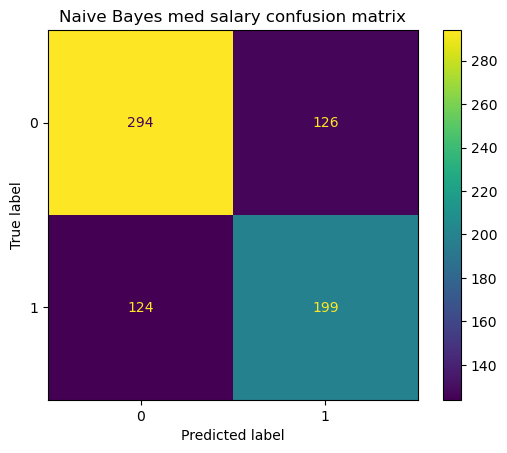

Precision: [0.70334928 0.61230769]
Recall: [0.7        0.61609907]
Fscore: [0.70167064 0.61419753]


In [ ]:
# creating the confusion matrix for median salary
predictions_med = nb_classifier2.predict(X_test_med)
med_conf = confusion_matrix(y_test_med, predictions_med)
disp = ConfusionMatrixDisplay(confusion_matrix=med_conf)
disp.plot()
plt.title('Naive Bayes med salary confusion matrix')
plt.show()
precision, recall, fscore, _ = precision_recall_fscore_support(y_test_med, predictions_med)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Fscore: {fscore}')

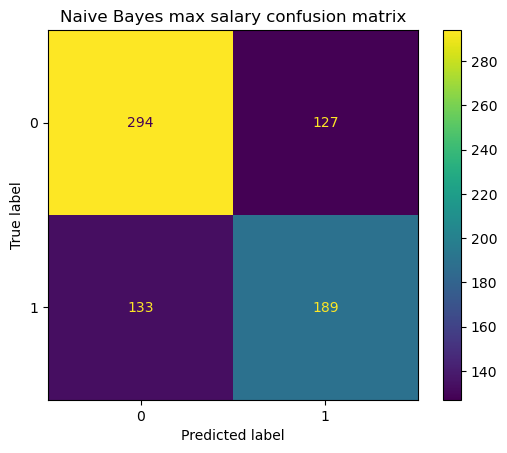

Precision: [0.68852459 0.59810127]
Recall: [0.69833729 0.58695652]
Fscore: [0.69339623 0.59247649]


In [59]:
# creating the confusion matrix for maximum salary
predictions_max = nb_classifier3.predict(X_test_max)
max_conf = confusion_matrix(y_test_max, predictions_max)
disp = ConfusionMatrixDisplay(confusion_matrix=max_conf)
disp.plot()
plt.title('Naive Bayes max salary confusion matrix')
plt.show()
precision, recall, fscore, _ = precision_recall_fscore_support(y_test_max, predictions_max)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Fscore: {fscore}')

Algorithm source: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

### K Means

In [47]:
#employee count v, min salary v, max salary v, median salary v, industry v, location v,  formatted_experience_level v, formatted_work_type v, title v.
# we group similiarity between jobs in terms of salaries
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# reorgnaizing ordering of columns to make normalizing other columns except salaries easier
# salaries should dominate as similiarity between jobs in our and the problem's eyes is based on salaries
original_features = df.loc[:,'title':'industry'].drop(columns=['min_salary', 'max_salary', 'med_salary'])
original_features['min_salary'] = df['min_salary']
original_features['med_salary'] = df['med_salary']
original_features['max_salary'] = df['max_salary']

# scale the columns other than salaries
scaler = MinMaxScaler()
normalized_features = df.loc[:,'title':'industry'].drop(columns=['min_salary', 'max_salary', 'med_salary'])
normalized_features.loc[:,'title':'industry'] = scaler.fit_transform(original_features.loc[:, 'title':'industry'])
normalized_features['min_salary'] = df['min_salary']
normalized_features['med_salary'] = df['med_salary']
normalized_features['max_salary'] = df['max_salary']

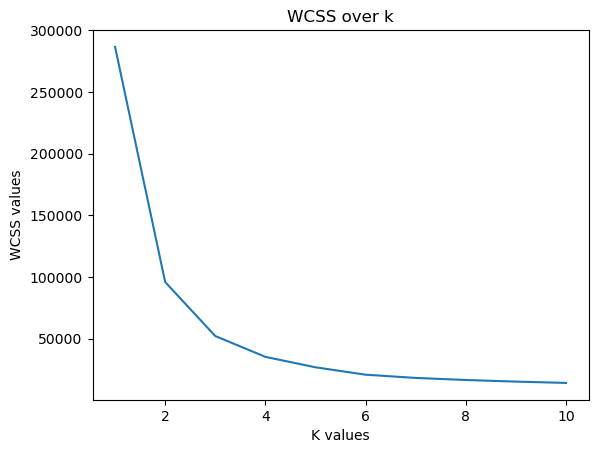

In [48]:
# trying to find optimal value for kmeans
wcss_array = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(normalized_features)
    wcss_array.append(kmeans.inertia_) # keep track of wcss values for elbow plot
    
plt.plot(range(1,11), wcss_array)
plt.title('WCSS over k')
plt.xlabel("K values")
plt.ylabel("WCSS values")
plt.show()

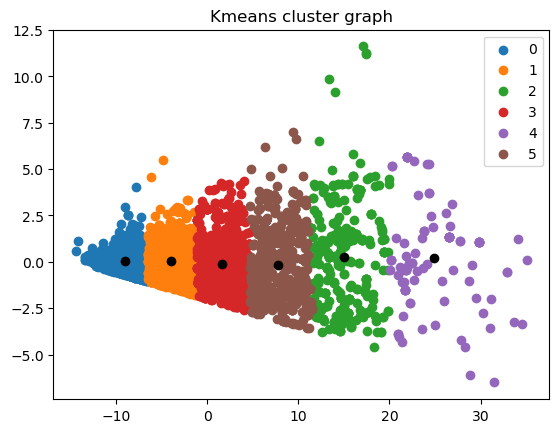

In [49]:
import sklearn.decomposition
# k means graph with PCA 
reduced_points = sklearn.decomposition.PCA(n_components=2).fit_transform(normalized_features)

# show k means clusters with optimal k value 6
kmeans_reduced = KMeans(n_clusters=6, n_init='auto')
kmeans_reduced.fit(reduced_points)


reduced_clusters = [[], [], [], [], [], []]

for i in range(len(kmeans_reduced.labels_)):
    cluster_id = kmeans_reduced.labels_[i]
    reduced_clusters[cluster_id -1].append(reduced_points[i])

for i in range(0, len(reduced_clusters)):
    plt.scatter([point[0] for point in reduced_clusters[i]] ,[point[1] for point in reduced_clusters[i]], label=i  )

# make the centroids stand out
reduced_centroids = kmeans_reduced.cluster_centers_
for centroid in reduced_centroids:
    plt.scatter(centroid[0], centroid[1], c='black')

plt.legend()
plt.title('Kmeans cluster graph')
plt.show()

In [50]:
# looks like 6 is the optimal k value here as it's the elbow
kmeans = KMeans(n_clusters=6, n_init='auto')
kmeans.fit(normalized_features)

# define the centroids and clusters
centroids = kmeans.cluster_centers_
clusters = [[], [], [], [], [], []]

for i in range(len(original_features)):
    cluster_id = kmeans.labels_[i]
    clusters[cluster_id].append(list(original_features.iloc[i].values))

print('\nNumber of samples per cluster')
for i in range(6):
    print(len(clusters[i]))



Number of samples per cluster
317
1006
101
747
952
589


In [51]:
print(kmeans.labels_[0])
kmeans.predict([[768.0, 3.0, 50.0, 3.0, 5.0, 42.0, 15.20, 19.0, 22.8]]) # seeing if the predicted value for the first row gives consistent labeling.

1


E:\anaconda3\envs\proj_587\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([1])

In [52]:
clusters = [[], [], [], [], [], []]
for i in range(len(original_features)):
    cluster_id = kmeans.labels_[i]
    clusters[cluster_id].append(original_features.iloc[i])

# checking the type of information in each cluster
for i in range(len(clusters)):
    min_min = 100
    min_med = 100
    min_max = 100
    
    max_min = 0
    max_med = 0
    max_max = 0
    for j in range(len(clusters[i])):
        if clusters[i][j].min_salary < min_min:
            min_min = clusters[i][j].min_salary
        if clusters[i][j].med_salary < min_med:
            min_med = clusters[i][j].med_salary
        if clusters[i][j].max_salary < min_max:
            min_max = clusters[i][j].max_salary
        
        if clusters[i][j].min_salary > max_min:
            max_min = clusters[i][j].min_salary
        if clusters[i][j].med_salary > max_med:
            max_med = clusters[i][j].med_salary
        if clusters[i][j].max_salary > max_max:
            max_max = clusters[i][j].max_salary
            
        
    print(f'Cluster {i}')
    print(f'lowest min {min_min}')
    print(f'lowest med {min_med}')
    print(f'lowest max {min_max}')
    print(f'highest min {max_min}')
    print(f'highest med {max_med}')
    print(f'highest max {max_max}')
    print('\n')

Cluster 0
lowest min 7.2
lowest med 16.3
lowest max 17.5
highest min 20.8
highest med 21.25
highest max 30.0


Cluster 1
lowest min 1.0
lowest med 1.67815
lowest max 2.0063
highest min 6.25456
highest med 6.25456
highest max 8.53


Cluster 2
lowest min 14.11
lowest med 21.0
lowest max 23.0
highest min 28.5
highest med 30.0
highest max 35.0


Cluster 3
lowest min 5.6136
lowest med 9.15
lowest max 9.6006
highest min 12.5
highest med 12.75
highest max 16.72


Cluster 4
lowest min 2.0
lowest med 6.0403199999999995
lowest max 6.448
highest min 9.36
highest med 9.36
highest max 12.064


Cluster 5
lowest min 6.7
lowest med 12.29725
lowest max 13.0
highest min 16.64
highest med 16.64
highest max 22.0




### NN

In [50]:
# Prepare data for neural network

target = df[['min_salary', 'med_salary', 'max_salary']]
train_df = df.drop(columns=['min_salary', 'med_salary', 'max_salary'])

features_to_drop = ['job_id', 'title', 'company_id', 'company_size']

train_df = train_df.drop(columns=features_to_drop)

X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=42)

In [54]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [55]:
history = model.fit(X_train.astype('float'), y_train.astype('float'), epochs=200, batch_size=16 ,validation_split=0.2, callbacks=callback, verbose=1)

Epoch 1/200
149/149 [==============================] - 1s 2ms/step - loss: 4.8548 - mae: 4.8548 - mse: 43.0179 - val_loss: 2.6813 - val_mae: 2.6813 - val_mse: 14.1250
Epoch 2/200
149/149 [==============================] - 0s 2ms/step - loss: 2.5344 - mae: 2.5344 - mse: 12.4359 - val_loss: 2.0215 - val_mae: 2.0215 - val_mse: 8.3708
Epoch 3/200
149/149 [==============================] - 0s 2ms/step - loss: 2.2995 - mae: 2.2995 - mse: 10.5315 - val_loss: 1.9146 - val_mae: 1.9146 - val_mse: 7.1957
Epoch 4/200
149/149 [==============================] - 0s 1ms/step - loss: 2.2062 - mae: 2.2062 - mse: 9.6314 - val_loss: 1.8565 - val_mae: 1.8565 - val_mse: 7.1577
Epoch 5/200
149/149 [==============================] - 0s 1ms/step - loss: 2.1915 - mae: 2.1915 - mse: 9.5802 - val_loss: 2.0848 - val_mae: 2.0848 - val_mse: 8.6889
Epoch 6/200
149/149 [==============================] - 0s 2ms/step - loss: 2.1384 - mae: 2.1384 - mse: 9.0183 - val_loss: 1.8729 - val_mae: 1.8729 - val_mse: 6.7792
Epoch 

In [56]:
y_pred = model.predict(X_test.astype('float'))
y_pred = pd.DataFrame(y_pred, columns=target.columns)

print(mean_absolute_error(y_test, y_pred))

24/24 [==============================] - 0s 778us/step
2.970376706519262


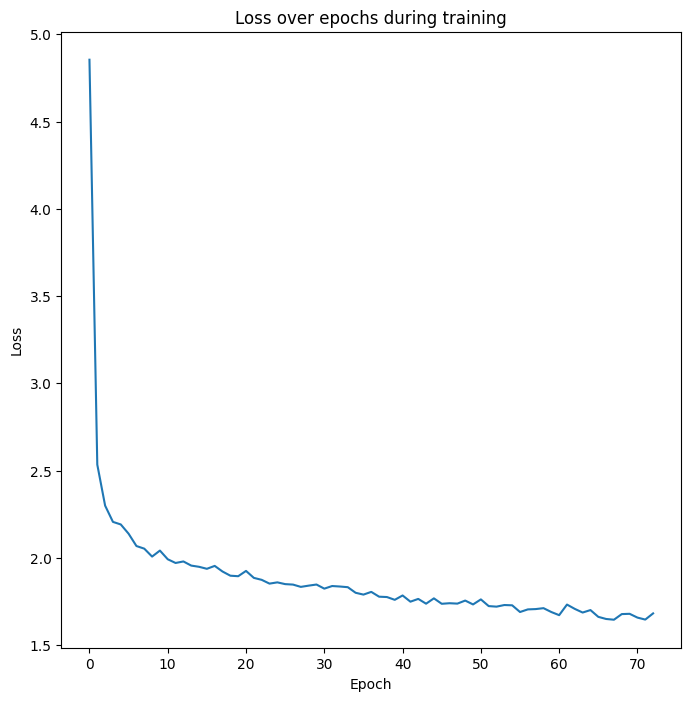

In [57]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='loss')
plt.title('Loss over epochs during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Decision Tree

In [31]:
# Prepare data for decision tree

target = df[['formatted_experience_level']]
features = df[['employee_count', 'industry', 'med_salary', 'title']]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [32]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train.astype(int))

pred = decision_tree.predict(X_test)

print(accuracy_score(np.array(y_test.astype(int)), pred))

0.6433378196500673


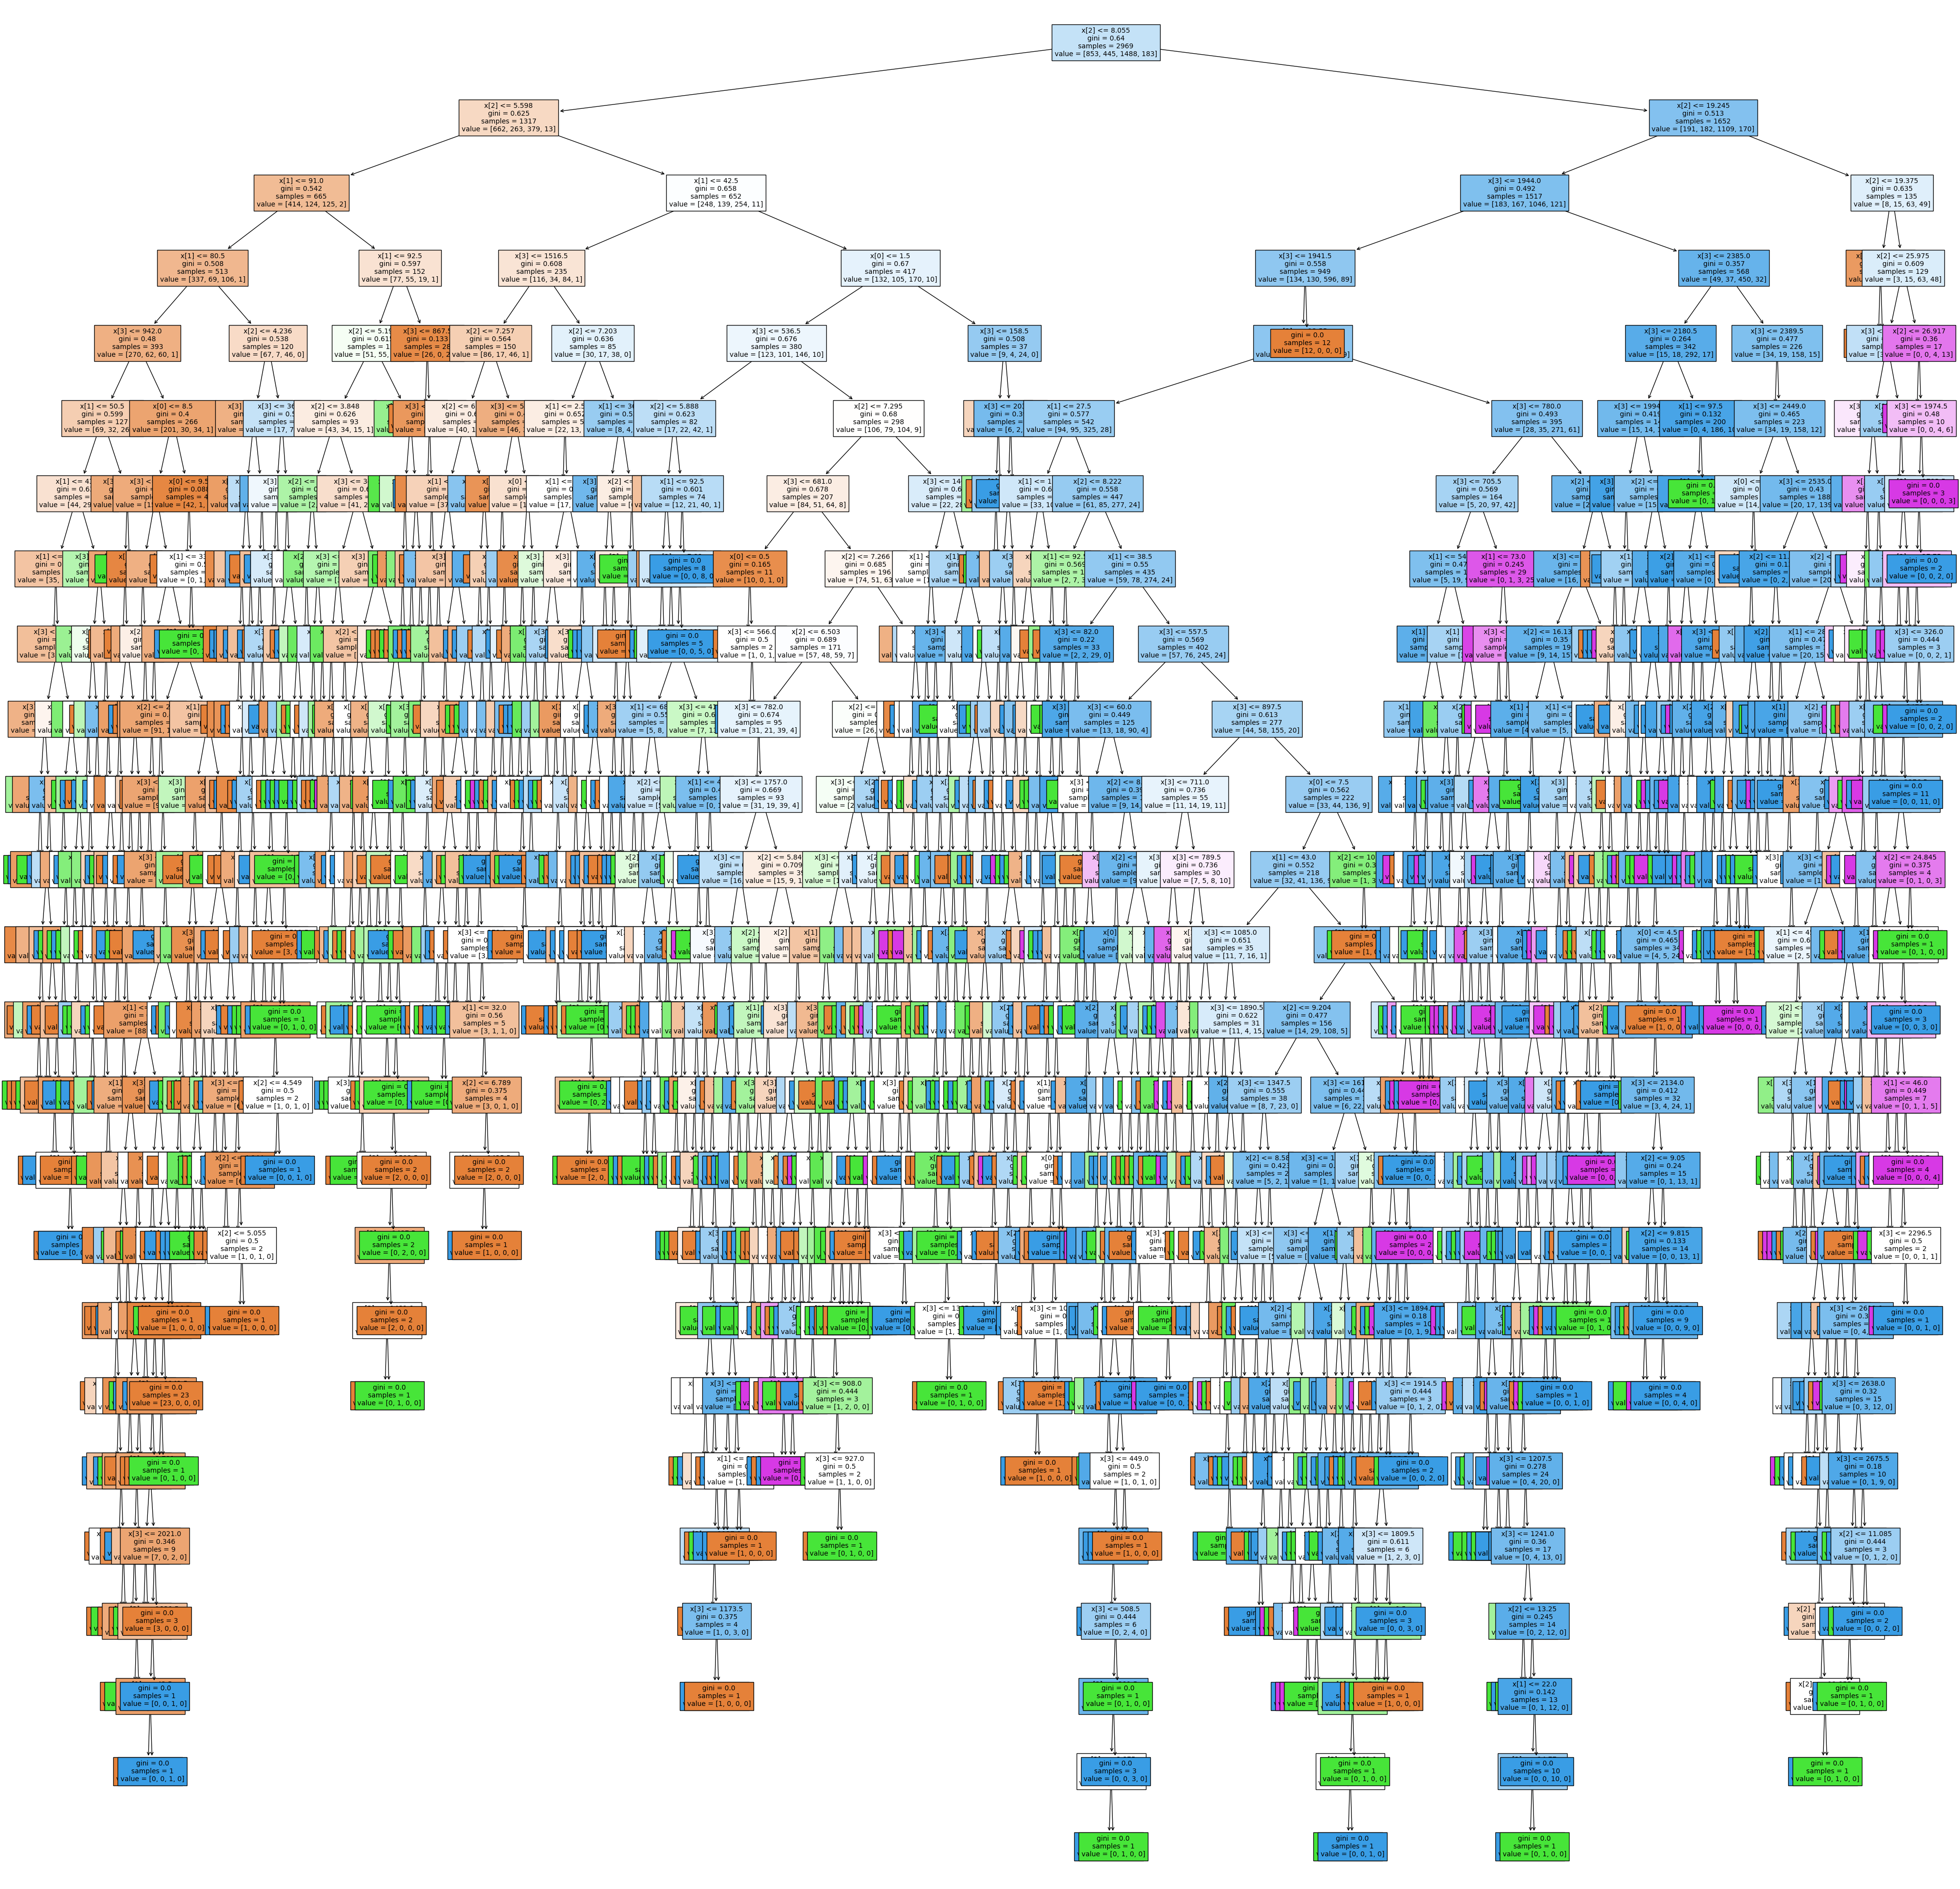

In [33]:
plt.figure(figsize=(50, 50))
tree.plot_tree(decision_tree, filled=True, fontsize=10)
plt.show()

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Prepare data for logistic regression
feature = df.drop(columns=['min_salary', 'med_salary', 'max_salary'])
target = df[['above_avg_min', 'above_avg_med', 'above_avg_max']]

features_to_drop = ['job_id', 'title','company_id', 'company_size','above_avg_min', 'above_avg_med', 'above_avg_max']

feature = feature.drop(columns=features_to_drop)

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

above_avg_min Accuracy: 0.7335127860026918


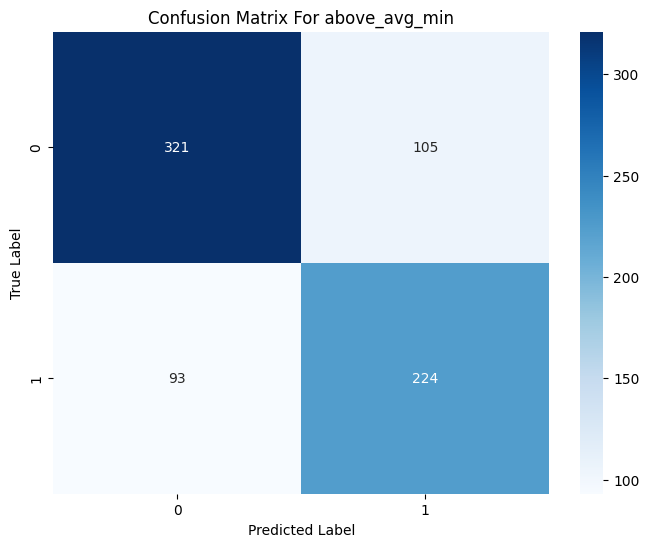

above_avg_med Accuracy: 0.7362045760430687


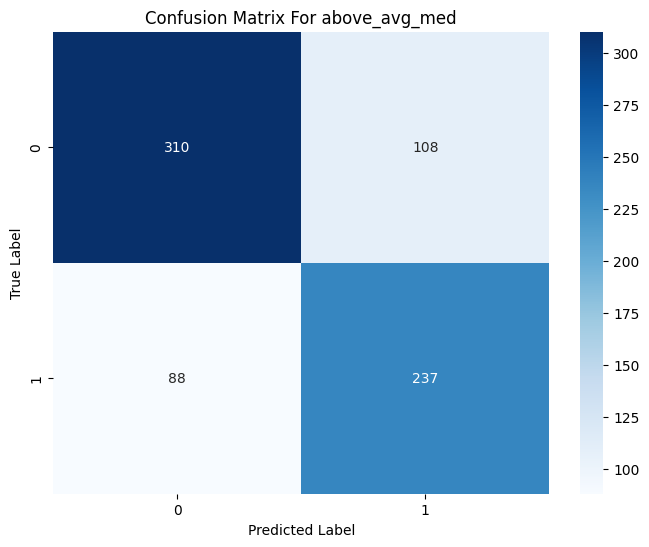

above_avg_max Accuracy: 0.7496635262449529


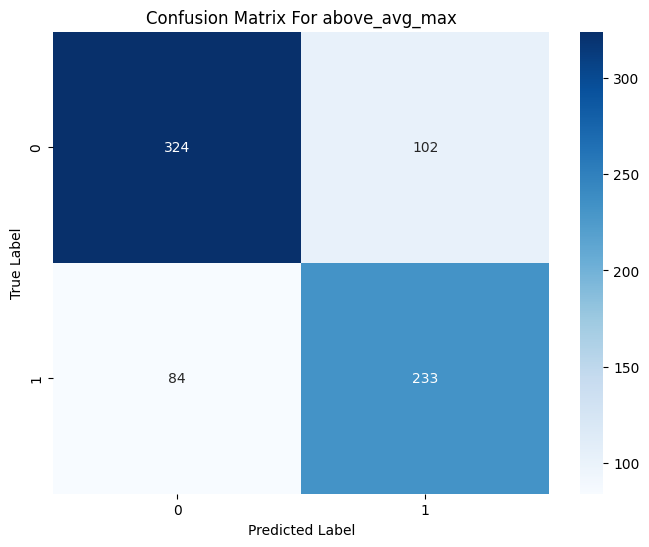

In [25]:
# create 3 logistic regression for above average min, med and max and visualize the result
for i in range(3):
    y_train_ = y_train.iloc[:,i].ravel()
    y_test_ = y_test.iloc[:,i].ravel()
    
    model = LogisticRegression(max_iter=1000)

    # Train the model
    model.fit(X_train, y_train_)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test_, y_pred)
    print(f'{y_train.iloc[:,i].name} Accuracy: {accuracy}')

    cm = confusion_matrix(y_test_, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix For {y_train.iloc[:,i].name}')
    plt.show()


### KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# Prepare data for knn
feature = df[['max_salary', 'med_salary', 'min_salary','company_size','employee_count', 'formatted_experience_level']]
target = df['industry']

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

In [40]:
# train and evulate the model
knn = KNeighborsClassifier(n_neighbors=15, weights="distance")
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'metric: {accuracy}')

metric: 0.477792732166891


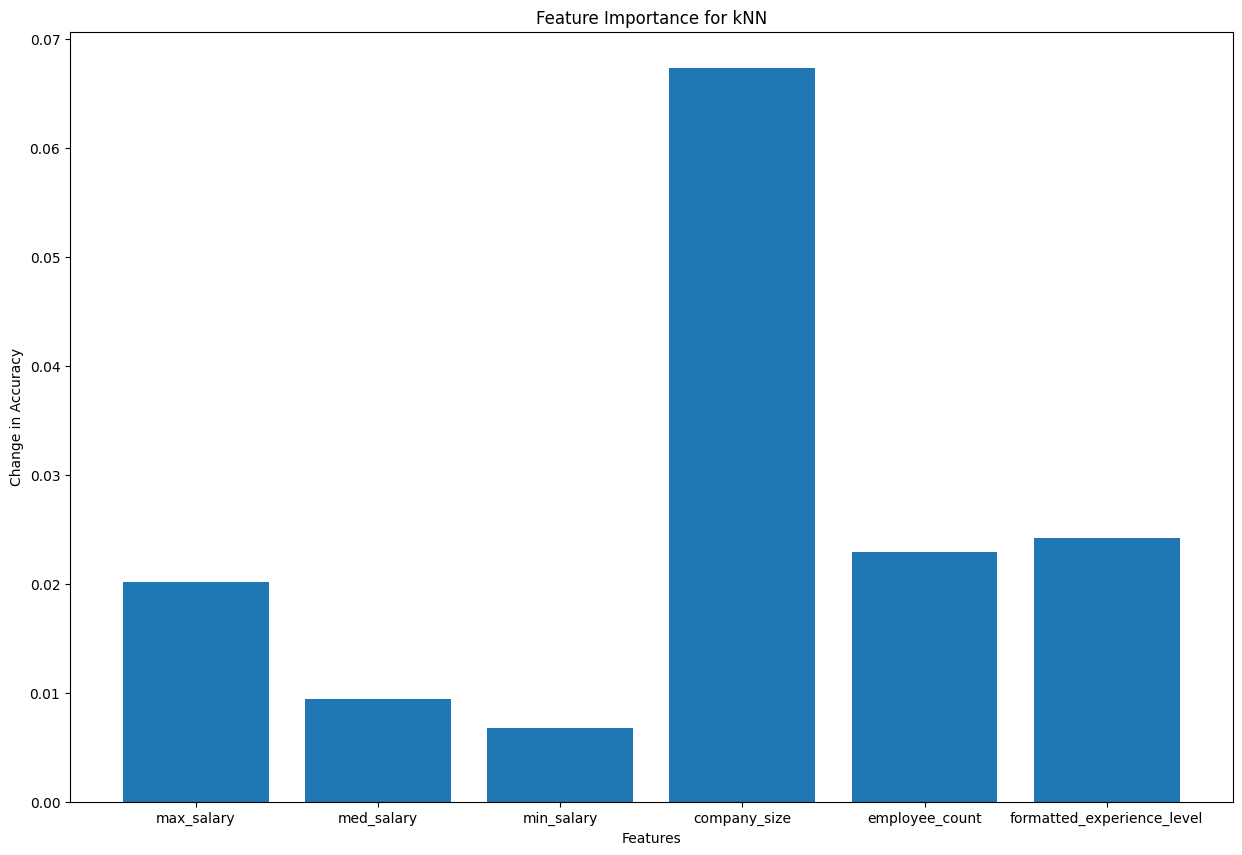

In [41]:
feature_importance = []
for i in range(feature.shape[1]):
    X_subset = np.delete(X_train, i, axis=1)
    knn.fit(X_subset, y_train)
    y_pred_subset = knn.predict(np.delete(X_test, i, axis=1))
    accuracy_subset = accuracy_score(y_test, y_pred_subset)
    feature_importance.append(accuracy - accuracy_subset)

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.bar(range(feature.shape[1]), feature_importance, tick_label=[f'{feature.iloc[:,i].name}' for i in range(feature.shape[1])])
plt.xlabel('Features')
plt.ylabel('Change in Accuracy')
plt.title('Feature Importance for kNN')
plt.show()